In [17]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import time
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Input
from keras.optimizers import SGD, Adam

# Enable eager execution
tf.config.run_functions_eagerly(True)

In [18]:
# Load MNIST dataset
print("Loading MNIST dataset...")
(x_train_full, y_train_full), (x_test, y_test) = mnist.load_data()

# Reduce training size by 1/10
print("Reducing training size by 1/10...")
n_samples = len(x_train_full) // 10
indices = np.random.choice(len(x_train_full), n_samples, replace=False)
x_train_reduced = x_train_full[indices]
y_train_reduced = y_train_full[indices]

print(f"Original training size: {len(x_train_full)}")
print(f"Reduced training size: {len(x_train_reduced)}")
print(f"Test size: {len(x_test)}")
print(f"Image shape: {x_train_reduced[0].shape}")

# Normalize pixel values to [0, 1]
x_train_reduced = x_train_reduced.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

Loading MNIST dataset...
Reducing training size by 1/10...
Original training size: 60000
Reduced training size: 6000
Test size: 10000
Image shape: (28, 28)


In [19]:
import numpy as np
from scipy.interpolate import Rbf

def convert_28x28_to_32x32_rbf(images):
    """
    Convert 28x28 images to 32x32 using RBF transformation.
    This version applies a Gaussian filter to the padded image.
    """
    n_samples = images.shape[0]
    new_images = np.zeros((n_samples, 32, 32))
    print("\nConverting 28x28 images to 32x32 using RBF transformation...")

    # Vectorized approach to calculate center and standard deviation for RBF
    # Mean of each image (center)
    center = np.mean(images, axis=(1, 2))
    # Std of each image
    std = np.std(images, axis=(1, 2))
    
    # Loop through samples for individual image processing
    for i in range(n_samples):
        if i % 1000 == 0:
            print(f"Processing image {i+1}/{n_samples}")
            
        # Pad with 2 pixels on each side to resize from 28x28 to 32x32
        padded = np.pad(images[i], ((2, 2), (2, 2)), mode='constant', constant_values=0)
        
        # Apply RBF transformation based on the Gaussian filter logic
        if std[i] > 0:
            # Calculate the RBF factor
            rbf_factor = np.exp(-((padded - center[i]) ** 2) / (2 * std[i] ** 2))
            new_images[i] = padded * rbf_factor
        else:
            # Handle cases where standard deviation is zero (flat image)
            new_images[i] = padded
            
    return new_images

def convert_28x28_to_32x32_rbf_scipy(images):
    """
    Convert 28x28 images to 32x32 using SciPy's RBF interpolation.
    This function uses true RBF interpolation, not just a Gaussian filter.
    """
    n_samples, h, w = images.shape
    new_images = np.zeros((n_samples, 32, 32))
    
    print("\nConverting 28x28 images to 32x32 using SciPy's RBF interpolation...")
    
    # Define the grid for the original 28x28 and the new 32x32 image
    old_x, old_y = np.meshgrid(np.arange(w), np.arange(h))
    new_x, new_y = np.meshgrid(np.linspace(0, w-1, 32), np.linspace(0, h-1, 32))
    
    for i in range(n_samples):
        if i % 1000 == 0:
            print(f"Processing image {i+1}/{n_samples}")
        
        
        interp = Rbf(old_x.flatten(), old_y.flatten(), images[i].flatten(), function='linear')
        
        # Apply the interpolator to the new grid
        new_images[i] = interp(new_x, new_y)
        
    return new_images

# Convert the actual MNIST data (not random data!)
# Use the x_train_reduced and x_test from the previous cell (cell 2)
print("\n=== Converting MNIST Training Data ===")
x_train_32x32 = convert_28x28_to_32x32_rbf(x_train_reduced)

print("\n=== Converting MNIST Test Data ===")
x_test_32x32 = convert_28x28_to_32x32_rbf(x_test)

print("\n--- Conversion Complete ---")
print(f"Training data shape: {x_train_32x32.shape}")
print(f"Test data shape: {x_test_32x32.shape}")
print(f"New image dimensions: 32x32")

# Optional: Uncomment below to use SciPy's RBF instead
# x_train_32x32 = convert_28x28_to_32x32_rbf_scipy(x_train_reduced)
# x_test_32x32 = convert_28x28_to_32x32_rbf_scipy(x_test)



=== Converting MNIST Training Data ===

Converting 28x28 images to 32x32 using RBF transformation...
Processing image 1/6000
Processing image 1001/6000
Processing image 2001/6000
Processing image 3001/6000
Processing image 4001/6000
Processing image 5001/6000

=== Converting MNIST Test Data ===

Converting 28x28 images to 32x32 using RBF transformation...
Processing image 1/10000
Processing image 1001/10000
Processing image 2001/10000
Processing image 3001/10000
Processing image 4001/10000
Processing image 5001/10000
Processing image 6001/10000
Processing image 7001/10000
Processing image 8001/10000
Processing image 9001/10000

--- Conversion Complete ---
Training data shape: (6000, 32, 32)
Test data shape: (10000, 32, 32)
New image dimensions: 32x32


In [20]:
# Split dataset: 80% training, 10% validation, 10% test
print("\\nSplitting dataset...")

# First split: 80% train, 20% temp
x_train_split, x_temp, y_train_split, y_temp = train_test_split(
    x_train_32x32, y_train_reduced, test_size=0.2, random_state=42, stratify=y_train_reduced
)

# Second split: 10% validation, 10% test from the temp set
x_val, x_test_split, y_val, y_test_split = train_test_split(
    x_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Training set: {x_train_split.shape[0]} samples")
print(f"Validation set: {x_val.shape[0]} samples") 
print(f"Test set: {x_test_split.shape[0]} samples")
print(f"Original test set: {x_test_32x32.shape[0]} samples")

# Flatten the images for neural network input
x_train_flat = x_train_split.reshape(x_train_split.shape[0], -1)
x_val_flat = x_val.reshape(x_val.shape[0], -1)
x_test_flat = x_test_split.reshape(x_test_split.shape[0], -1)
x_test_original_flat = x_test_32x32.reshape(x_test_32x32.shape[0], -1)

print(f"\\nFlattened shapes:")
print(f"Training: {x_train_flat.shape}")
print(f"Validation: {x_val_flat.shape}")
print(f"Test: {x_test_flat.shape}")

# Convert labels to categorical for some experiments
y_train_cat = to_categorical(y_train_split, 10)
y_val_cat = to_categorical(y_val, 10)
y_test_cat = to_categorical(y_test_split, 10)
y_test_original_cat = to_categorical(y_test, 10)

\nSplitting dataset...
Training set: 4800 samples
Validation set: 600 samples
Test set: 600 samples
Original test set: 10000 samples
\nFlattened shapes:
Training: (4800, 1024)
Validation: (600, 1024)
Test: (600, 1024)


In [ ]:
# Function to create neural network models
def create_model(hidden_layers, activation='sigmoid', dropout_rate=0.0, input_shape=1024):
    """
    Create a neural network model with specified architecture
    
    Args:
        hidden_layers: List of hidden layer sizes (e.g., [16], [16, 32], [16, 32, 64])
        activation: Activation function ('sigmoid', 'tanh', 'relu')
        dropout_rate: Dropout rate (0.0 means no dropout)
        input_shape: Input dimension (32x32 = 1024)
    
    Returns:
        Keras Sequential model
    """
    model = Sequential()
    
    # Add input layer explicitly
    model.add(Input(shape=(input_shape,)))
    
    # Add first hidden layer
    model.add(Dense(hidden_layers[0], activation=activation))
    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))
    
    # Add additional hidden layers
    for neurons in hidden_layers[1:]:
        model.add(Dense(neurons, activation=activation))
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate))
    
    # Output layer
    model.add(Dense(10, activation='softmax'))
    
    return model

# Function to train and evaluate model
def train_evaluate_model(model, optimizer, loss, x_train, y_train, x_val, y_val, 
                        x_test, y_test, epochs=10, verbose=0):
    """
    Train and evaluate a model
    
    Returns:
        history, test_accuracy, training_time
    """
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    
    start_time = time.time()
    history = model.fit(x_train, y_train, 
                       validation_data=(x_val, y_val),
                       epochs=epochs, 
                       batch_size=128,
                       verbose=verbose)
    training_time = time.time() - start_time
    
    # Evaluate on test set
    test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
    
    return history, test_accuracy, training_time

In [22]:
# Experiment 1: Different optimizers and hidden layers (reduced epochs for demonstration)
results_exp1 = []

# Define configurations
hidden_layer_configs = [
    [16],
    [16, 32], 
    [16, 32, 64]
]

# Function to create optimizers (to avoid reusing them)
def create_optimizer(opt_name, lr=0.001):
    if opt_name == 'SGD':
        return SGD(learning_rate=lr)
    elif opt_name == 'Adam':
        return Adam(learning_rate=lr)

optimizer_names = ['SGD', 'Adam']

print("Starting Experiment 1: Different Optimizers and Hidden Layer Configurations")
print("=" * 80)

for opt_name in optimizer_names:
    print(f"\\nTesting {opt_name} optimizer...")
    
    for hidden_layers in hidden_layer_configs:
        print(f"\\n  Hidden layers: {hidden_layers}")
        
        # Create fresh model and optimizer for each configuration
        model = create_model(hidden_layers, activation='sigmoid')
        optimizer = create_optimizer(opt_name)
        
        # Train and evaluate (reduced epochs for faster execution)
        history, test_acc, train_time = train_evaluate_model(
            model, optimizer, 'categorical_crossentropy',
            x_train_flat, y_train_cat,
            x_val_flat, y_val_cat,
            x_test_flat, y_test_cat,
            epochs=10, verbose=1  # Reduced from 30 to 10 epochs
        )
        
        # Store results
        results_exp1.append({
            'optimizer': opt_name,
            'loss': 'categorical_crossentropy',
            'hidden_layers': hidden_layers,
            'test_accuracy': test_acc,
            'training_time': train_time,
            'history': history
        })
        
        print(f"    Test Accuracy: {test_acc:.4f}")
        print(f"    Training Time: {train_time:.2f} seconds")

print("\\nExperiment 1 completed!")

Starting Experiment 1: Different Optimizers and Hidden Layer Configurations
\nTesting SGD optimizer...
\n  Hidden layers: [16]
Epoch 1/10
12/38 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1109 - loss: 2.3203

/home/uttam/ML-LAB/.venv/lib/python3.12/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1079 - loss: 2.3228 - val_accuracy: 0.1083 - val_loss: 2.3237
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1079 - loss: 2.3218 - val_accuracy: 0.1083 - val_loss: 2.3227
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1079 - loss: 2.3208 - val_accuracy: 0.1083 - val_loss: 2.3218
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1079 - loss: 2.3199 - val_accuracy: 0.1083 - val_loss: 2.3208
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1079 - loss: 2.3190 - val_accuracy: 0.1083 - val_loss: 2.3199
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1079 - loss: 2.3181 - val_accuracy: 0.1083 - val_loss: 2.3190
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.1079 - loss: 2.3172 - val_accuracy: 0.1083 - val_loss: 2.3182
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1079 - loss: 2.3165 - val_accuracy: 0.1083 - val_loss: 2.

In [23]:
# Experiment 2: Different activation functions (reduced epochs)
results_exp2 = []

activation_functions = ['sigmoid', 'tanh', 'relu']
hidden_layers = [16, 32, 64]

print("Starting Experiment 2: Different Activation Functions")
print("=" * 60)

for activation in activation_functions:
    print(f"\\nTesting {activation} activation function...")
    
    # Create model
    model = create_model(hidden_layers, activation=activation)
    
    # Train and evaluate (using Adam optimizer and categorical crossentropy)
    history, test_acc, train_time = train_evaluate_model(
        model, Adam(learning_rate=0.001), 'categorical_crossentropy',
        x_train_flat, y_train_cat,
        x_val_flat, y_val_cat,
        x_test_flat, y_test_cat,
        epochs=10, verbose=1  # Reduced epochs
    )
    
    # Store results
    results_exp2.append({
        'activation': activation,
        'hidden_layers': hidden_layers,
        'test_accuracy': test_acc,
        'training_time': train_time,
        'history': history
    })
    
    print(f"  Test Accuracy: {test_acc:.4f}")
    print(f"  Training Time: {train_time:.2f} seconds")

print("\\nExperiment 2 completed!")

Starting Experiment 2: Different Activation Functions
\nTesting sigmoid activation function...
Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.1023 - loss: 2.3314 - val_accuracy: 0.1083 - val_loss: 2.3002
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.1106 - loss: 2.2977 - val_accuracy: 0.1100 - val_loss: 2.2932
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.1227 - loss: 2.2920 - val_accuracy: 0.1100 - val_loss: 2.2865
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.1550 - loss: 2.2814 - val_accuracy: 0.1883 - val_loss: 2.2714
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.1958 - loss: 2.2617 - val_accuracy: 0.2517 - val_loss: 2.2440
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.2425 - loss: 2.2217 - val_accuracy: 0.2033 - val_loss: 2.1912
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.2281 - loss: 2.1479 - val_accuracy: 0.2250 - val_loss: 2.0958
Epoch 8/10
38/38

In [24]:
# Experiment 3: Different dropout rates (reduced epochs and fewer dropout values for speed)
results_exp3 = []

dropout_rates = [0.9, 0.75, 0.25, 0.5, 0.10]
hidden_layers = [16, 32, 64]

print("Starting Experiment 3: Different Dropout Rates")
print("=" * 50)

for dropout_rate in dropout_rates:
    print(f"\\nTesting dropout rate: {dropout_rate}")
    
    # Create model with dropout
    model = create_model(hidden_layers, activation='relu', dropout_rate=dropout_rate)
    
    # Train and evaluate
    history, test_acc, train_time = train_evaluate_model(
        model, Adam(learning_rate=0.001), 'categorical_crossentropy',
        x_train_flat, y_train_cat,
        x_val_flat, y_val_cat,
        x_test_flat, y_test_cat,
        epochs=10, verbose=1  # Reduced epochs
    )
    
    # Store results
    results_exp3.append({
        'dropout_rate': dropout_rate,
        'hidden_layers': hidden_layers,
        'test_accuracy': test_acc,
        'training_time': train_time,
        'history': history
    })
    
    print(f"  Test Accuracy: {test_acc:.4f}")
    print(f"  Training Time: {train_time:.2f} seconds")

print("\\nExperiment 3 completed!")

Starting Experiment 3: Different Dropout Rates
\nTesting dropout rate: 0.9
Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.1031 - loss: 2.3281 - val_accuracy: 0.1133 - val_loss: 2.3020
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.1071 - loss: 2.3056 - val_accuracy: 0.1100 - val_loss: 2.3016
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.1063 - loss: 2.3031 - val_accuracy: 0.1100 - val_loss: 2.3013
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.1083 - loss: 2.3009 - val_accuracy: 0.1100 - val_loss: 2.3010
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.1115 - loss: 2.3014 - val_accuracy: 0.1100 - val_loss: 2.3008
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.1088 - loss: 2.3012 - val_accuracy: 0.1100 - val_loss: 2.3007
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.1085 - loss: 2.3015 - val_accuracy: 0.1100 - val_loss: 2.3006
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━

Plotting results for Experiment 1...


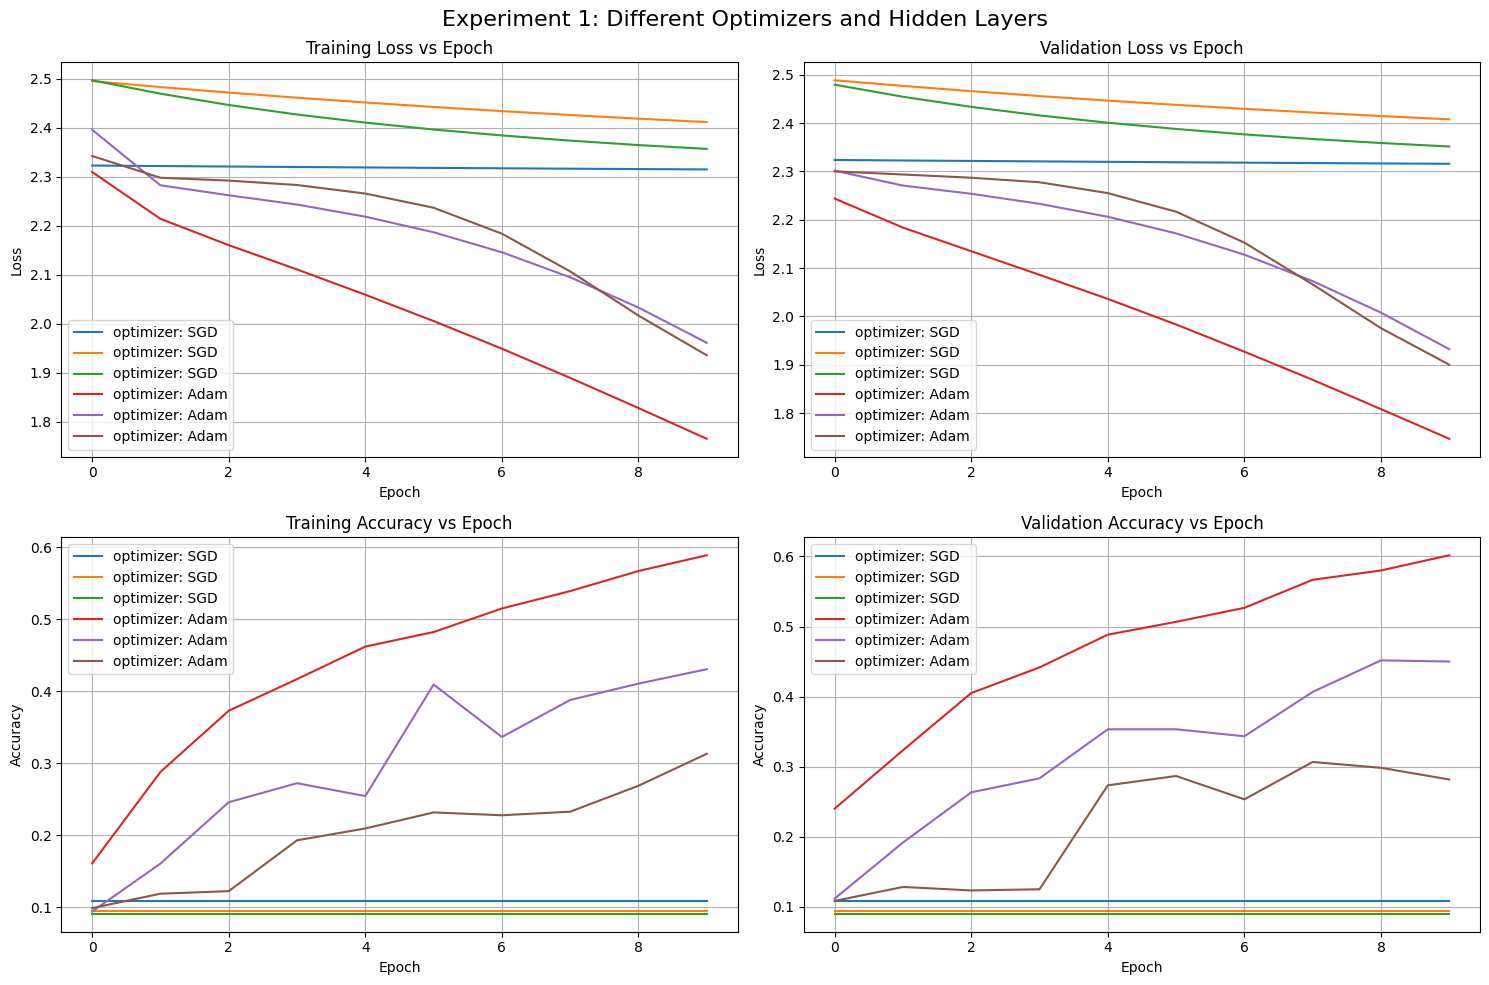

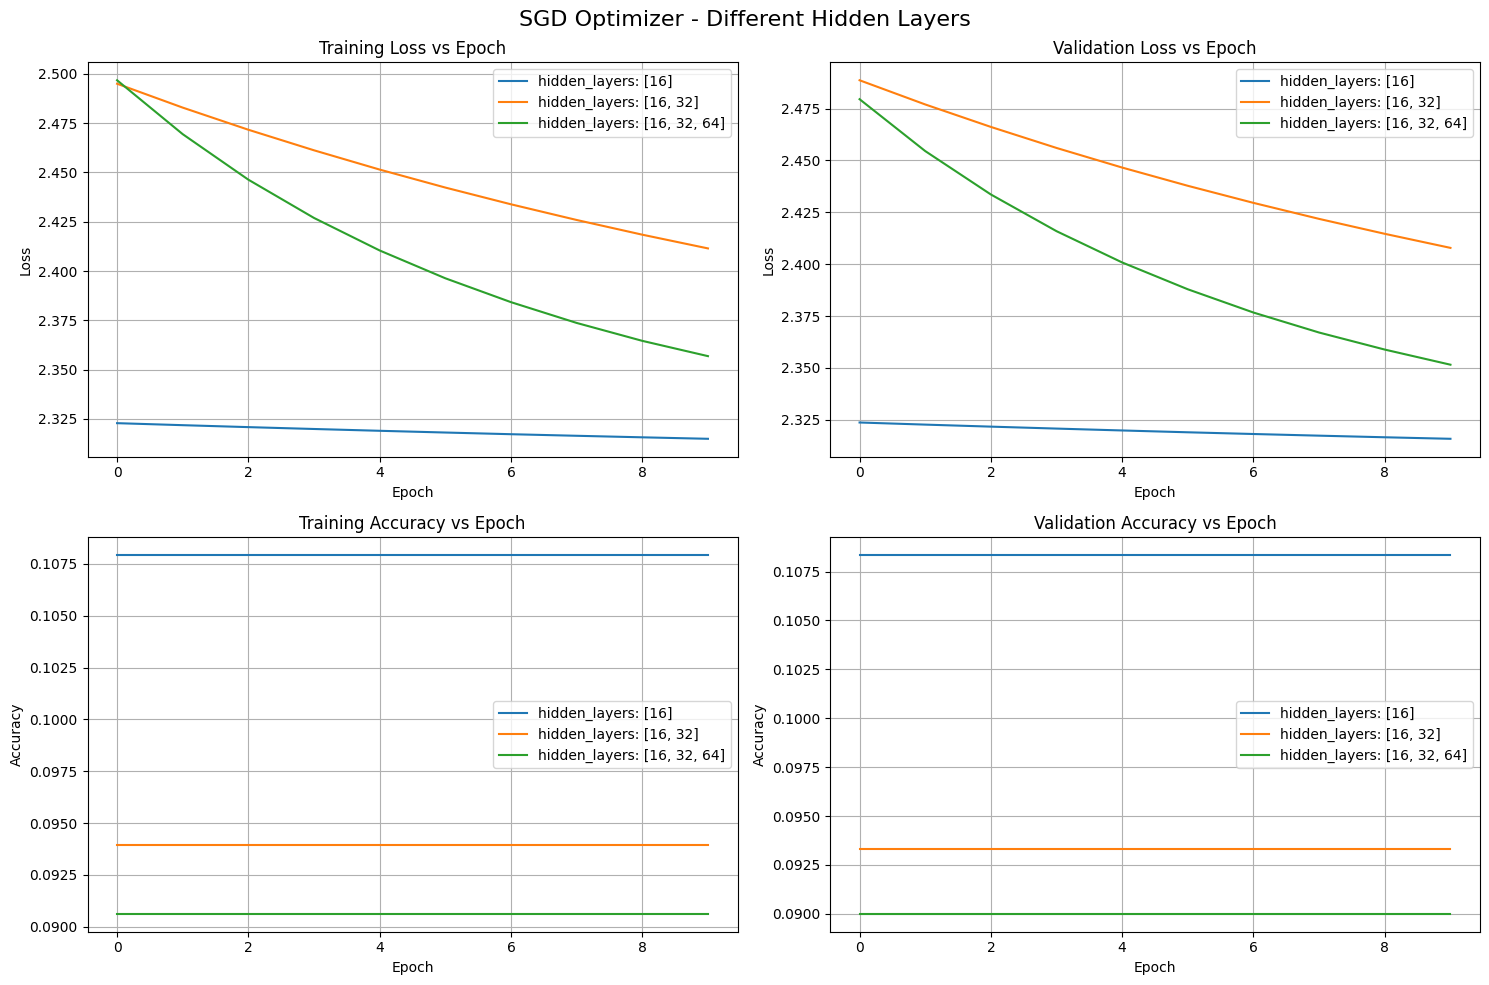

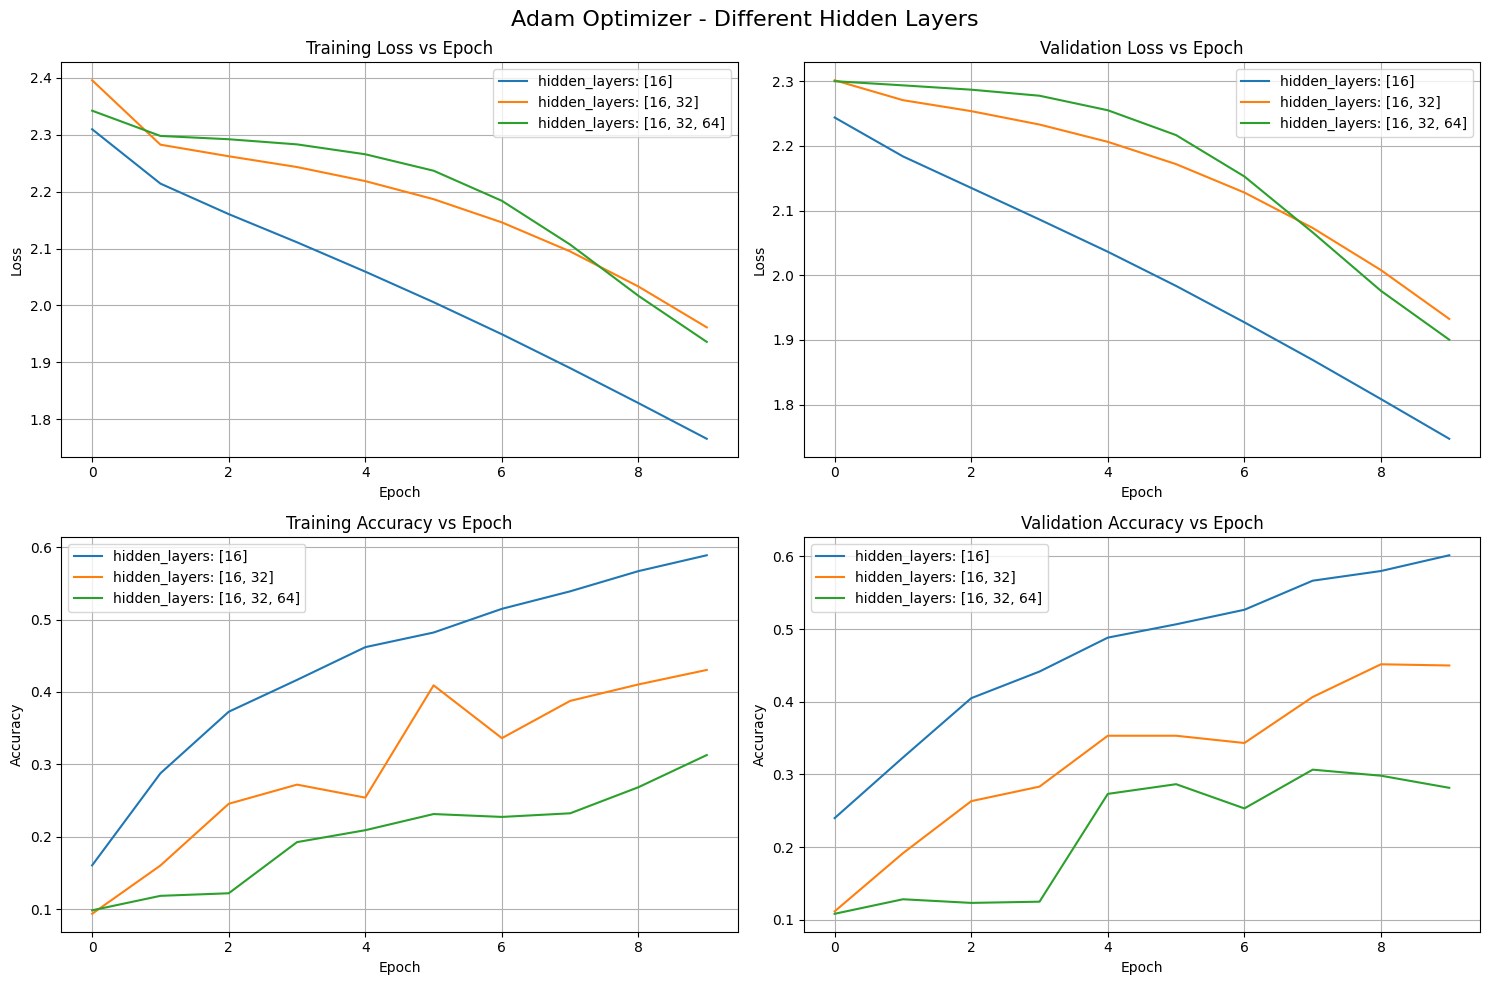

In [25]:
# Visualization functions
def plot_experiment_results(results, title, param_name):
    """
    Plot loss and accuracy curves for experiment results
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(title, fontsize=16)
    
    # Plot training loss
    axes[0, 0].set_title('Training Loss vs Epoch')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    
    # Plot validation loss
    axes[0, 1].set_title('Validation Loss vs Epoch')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    
    # Plot training accuracy
    axes[1, 0].set_title('Training Accuracy vs Epoch')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Accuracy')
    
    # Plot validation accuracy
    axes[1, 1].set_title('Validation Accuracy vs Epoch')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Accuracy')
    
    for result in results:
        history = result['history']
        label = str(result[param_name])
        
        # Plot losses
        axes[0, 0].plot(history.history['loss'], label=f'{param_name}: {label}')
        axes[0, 1].plot(history.history['val_loss'], label=f'{param_name}: {label}')
        
        # Plot accuracies
        axes[1, 0].plot(history.history['accuracy'], label=f'{param_name}: {label}')
        axes[1, 1].plot(history.history['val_accuracy'], label=f'{param_name}: {label}')

    # Add legends
    for ax in axes.flat:
        ax.legend()
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()

# Plot results for Experiment 1 (Different Optimizers)
print("Plotting results for Experiment 1...")
plot_experiment_results(results_exp1, 'Experiment 1: Different Optimizers and Hidden Layers', 'optimizer')

# Create separate plots for SGD and Adam
sgd_results = [r for r in results_exp1 if r['optimizer'] == 'SGD']
adam_results = [r for r in results_exp1 if r['optimizer'] == 'Adam']

if sgd_results:
    plot_experiment_results(sgd_results, 'SGD Optimizer - Different Hidden Layers', 'hidden_layers')

if adam_results:
    plot_experiment_results(adam_results, 'Adam Optimizer - Different Hidden Layers', 'hidden_layers')

\nPlotting results for Experiment 2...


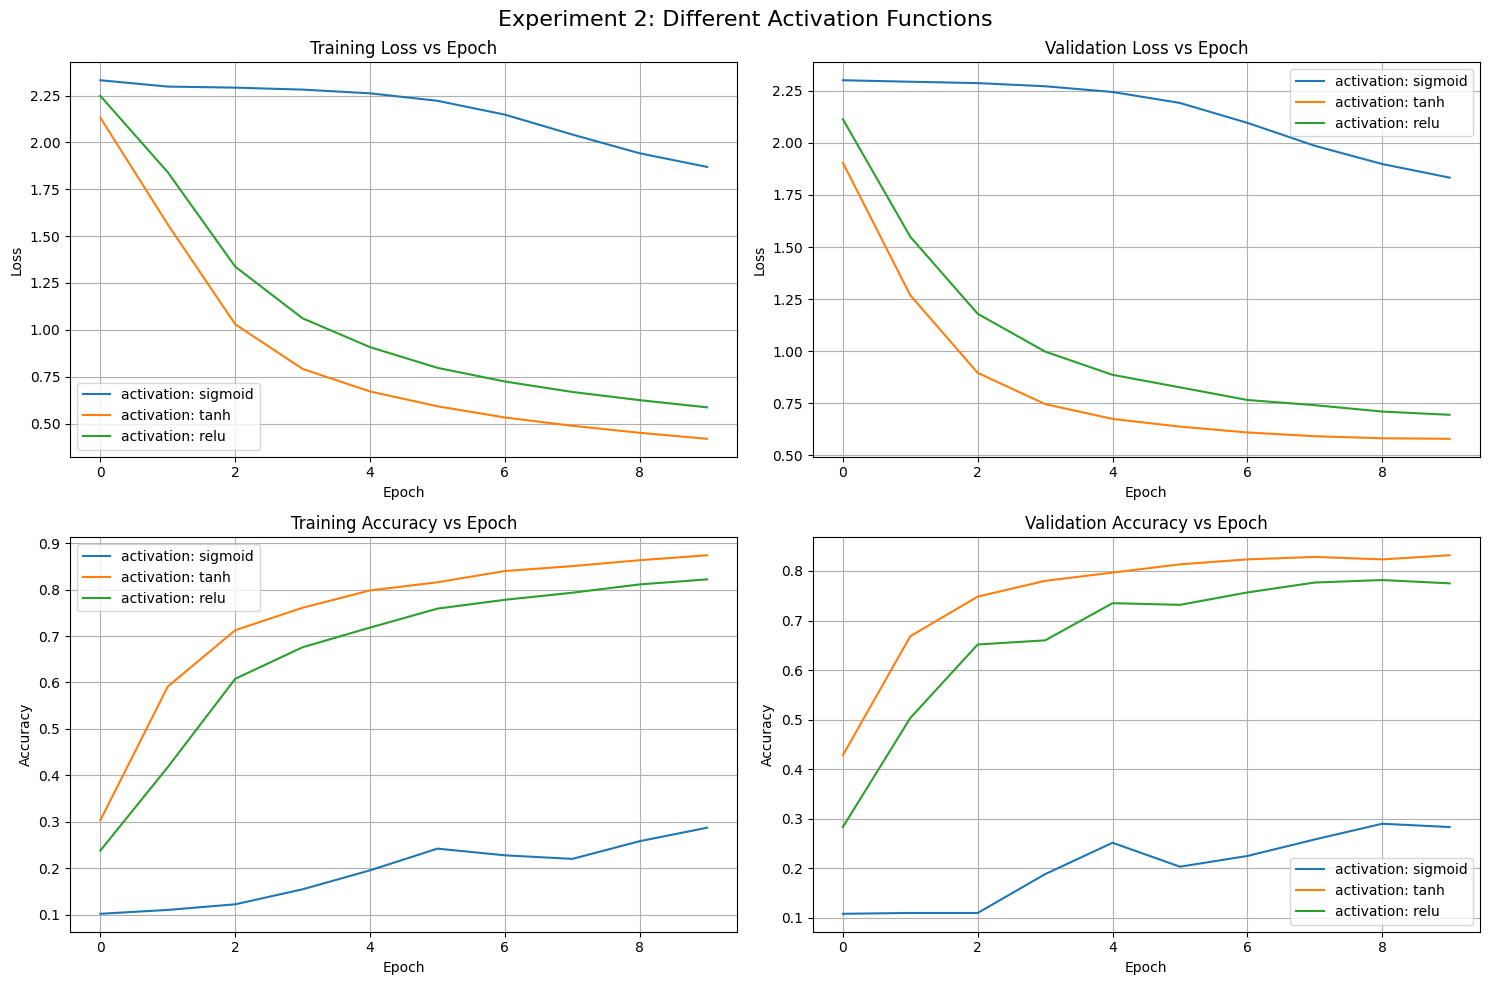

\nPlotting results for Experiment 3...


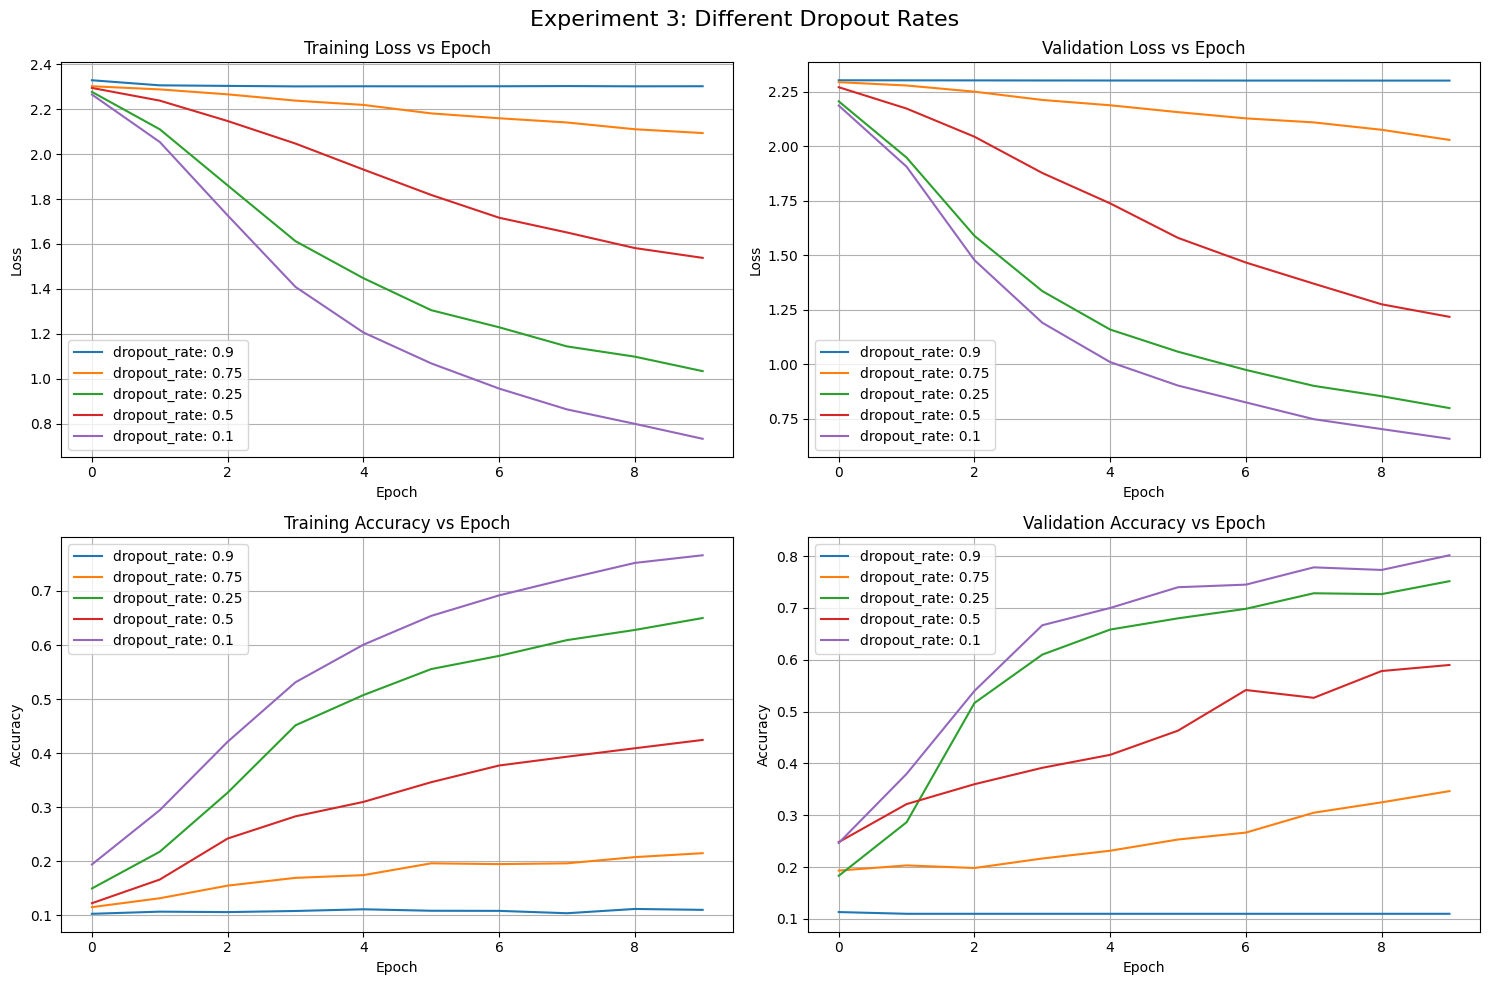

In [26]:
# Plot results for Experiment 2 (Different Activation Functions)
print("\\nPlotting results for Experiment 2...")
plot_experiment_results(results_exp2, 'Experiment 2: Different Activation Functions', 'activation')

# Plot results for Experiment 3 (Different Dropout Rates)
print("\\nPlotting results for Experiment 3...")
plot_experiment_results(results_exp3, 'Experiment 3: Different Dropout Rates', 'dropout_rate')

Finding best configuration from previous experiments...
Best configuration found:
  activation: tanh
  hidden_layers: [16, 32, 64]
  test_accuracy: 0.7916666865348816
  training_time: 10.445683717727661
\nStarting Experiment 4: Different Learning Rates
\nTesting learning rate: 0.01
Epoch 1/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.4573 - loss: 1.5294 - val_accuracy: 0.7017 - val_loss: 0.9312
Epoch 2/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7694 - loss: 0.7143 - val_accuracy: 0.8017 - val_loss: 0.6636
Epoch 3/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8402 - loss: 0.5011 - val_accuracy: 0.8217 - val_loss: 0.6360
Epoch 4/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8669 - loss: 0.4176 - val_accuracy: 0.8183 - val_loss: 0.6149
Epoch 5/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8902 - loss: 0.3359 - val_accuracy: 0.8250 - val_loss: 0.6449
Epoch 6/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9196 - loss: 0.25

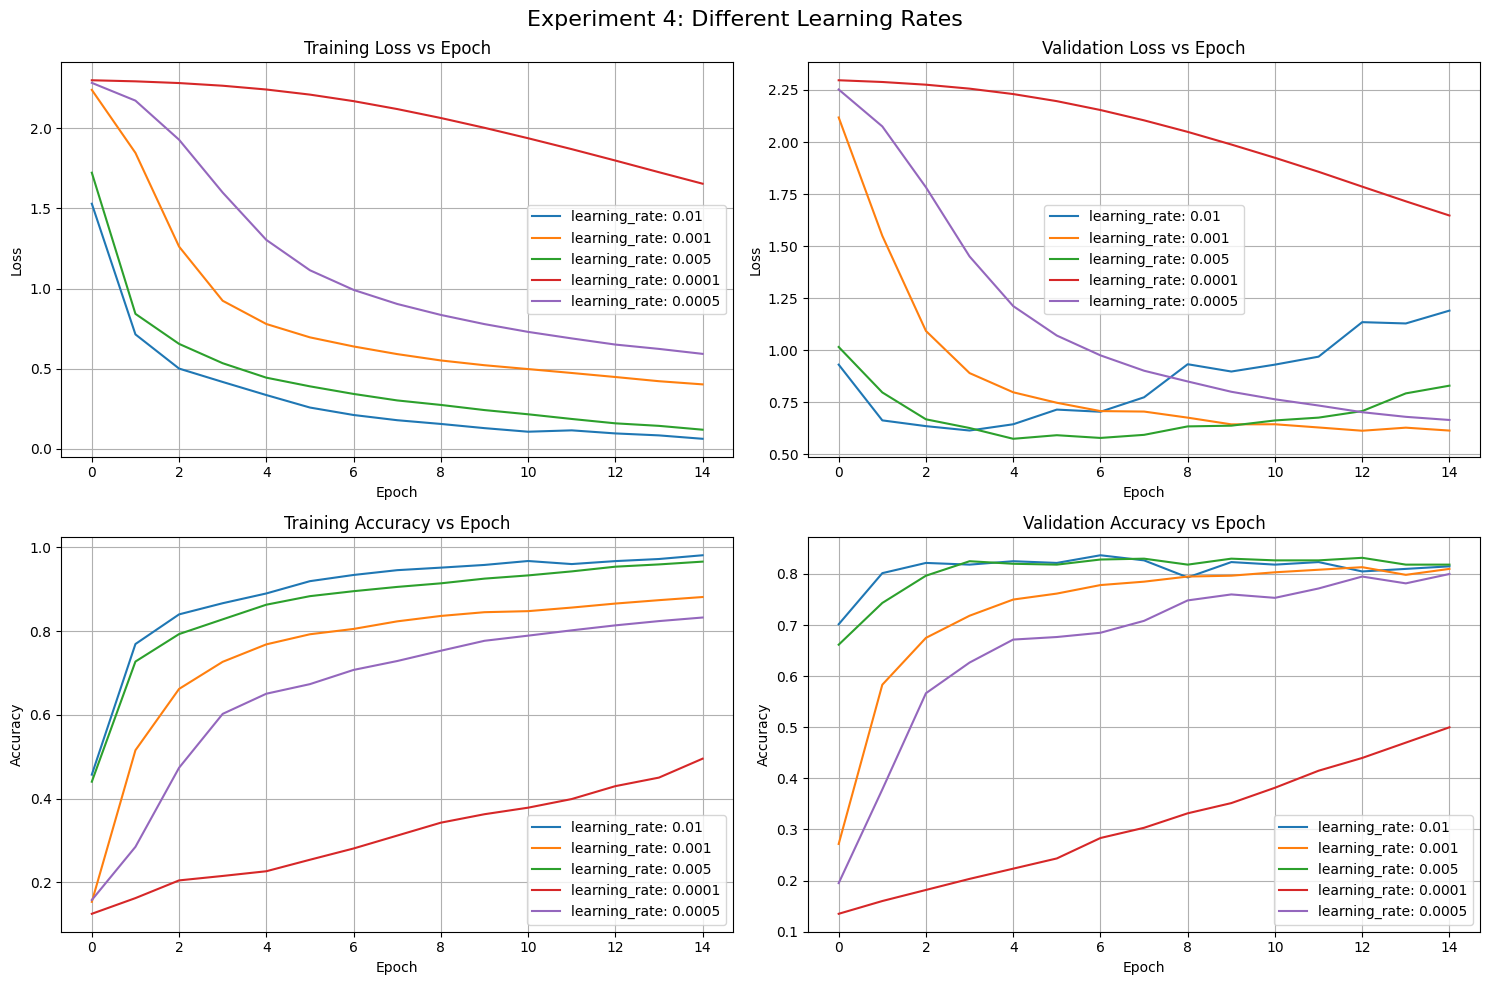

In [27]:
# Find the best configuration from previous experiments
print("Finding best configuration from previous experiments...")

all_results = results_exp1 + results_exp2 + results_exp3
best_result = max(all_results, key=lambda x: x['test_accuracy'])

print(f"Best configuration found:")
for key, value in best_result.items():
    if key != 'history':
        print(f"  {key}: {value}")

# Experiment 4: Different learning rates 
results_exp4 = []

learning_rates = [0.01, 0.001, 0.005, 0.0001, 0.0005] 
hidden_layers = [16, 32, 64]  # Use the best architecture

print("\\nStarting Experiment 4: Different Learning Rates")
print("=" * 50)

# Using ReLU activation 
for lr in learning_rates:
    print(f"\\nTesting learning rate: {lr}")
    
    # Create model
    model = create_model(hidden_layers, activation='relu')
    
    # Train and evaluate
    start_time = time.time()
    history, test_acc, train_time = train_evaluate_model(
        model, Adam(learning_rate=lr), 'categorical_crossentropy',
        x_train_flat, y_train_cat,
        x_val_flat, y_val_cat,
        x_test_flat, y_test_cat,
        epochs=15, verbose=1 
    )

    # Find time to achieve best validation accuracy
    best_val_acc_epoch = np.argmax(history.history['val_accuracy'])
    time_to_best = (best_val_acc_epoch + 1) * (train_time / len(history.history['val_accuracy']))
    
    # Store results
    results_exp4.append({
        'learning_rate': lr,
        'test_accuracy': test_acc,
        'training_time': train_time,
        'time_to_best_val_acc': time_to_best,
        'best_val_accuracy': max(history.history['val_accuracy']),
        'history': history
    })
    
    print(f"  Test Accuracy: {test_acc:.4f}")
    print(f"  Best Validation Accuracy: {max(history.history['val_accuracy']):.4f}")
    print(f"  Training Time: {train_time:.2f} seconds")
    print(f"  Time to Best Validation Accuracy: {time_to_best:.2f} seconds")

print("\\nExperiment 4 completed!")

# Plot learning rate results
print("\\nPlotting learning rate results...")
plot_experiment_results(results_exp4, 'Experiment 4: Different Learning Rates', 'learning_rate')

Selecting real MNIST test samples for digits 0-4...


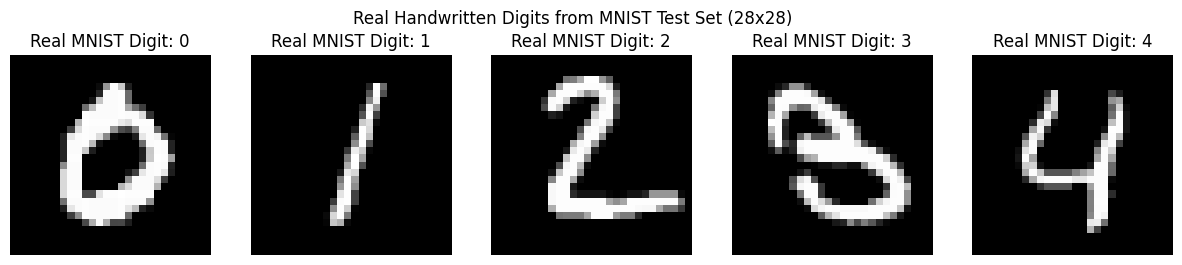


Converting handwritten digits to 32x32 using RBF...

Converting 28x28 images to 32x32 using RBF transformation...
Processing image 1/5

Using best model configuration:
Test accuracy: 0.8150
Hidden layers: [16, 32, 64]
Activation: relu
Dropout rate: 0.0
Learning rate: 0.001

Training the best model...
Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.2417 - loss: 2.2324 - val_accuracy: 0.2950 - val_loss: 2.0689
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.2417 - loss: 2.2324 - val_accuracy: 0.2950 - val_loss: 2.0689
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.3917 - loss: 1.8435 - val_accuracy: 0.5383 - val_loss: 1.6073
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.3917 - loss: 1.8435 - val_accuracy: 0.5383 - val_loss: 1.6073
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6102 - loss: 1.4375 - val_accuracy: 0.6867 - val_loss: 1.2632
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy:

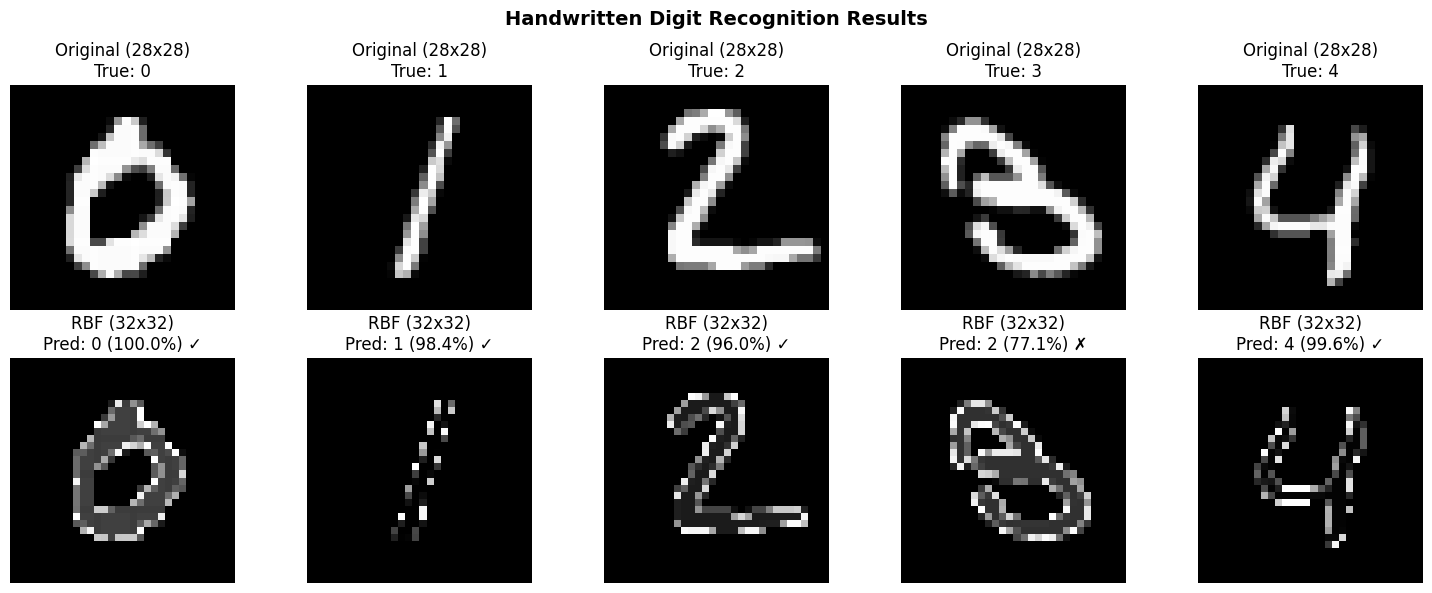

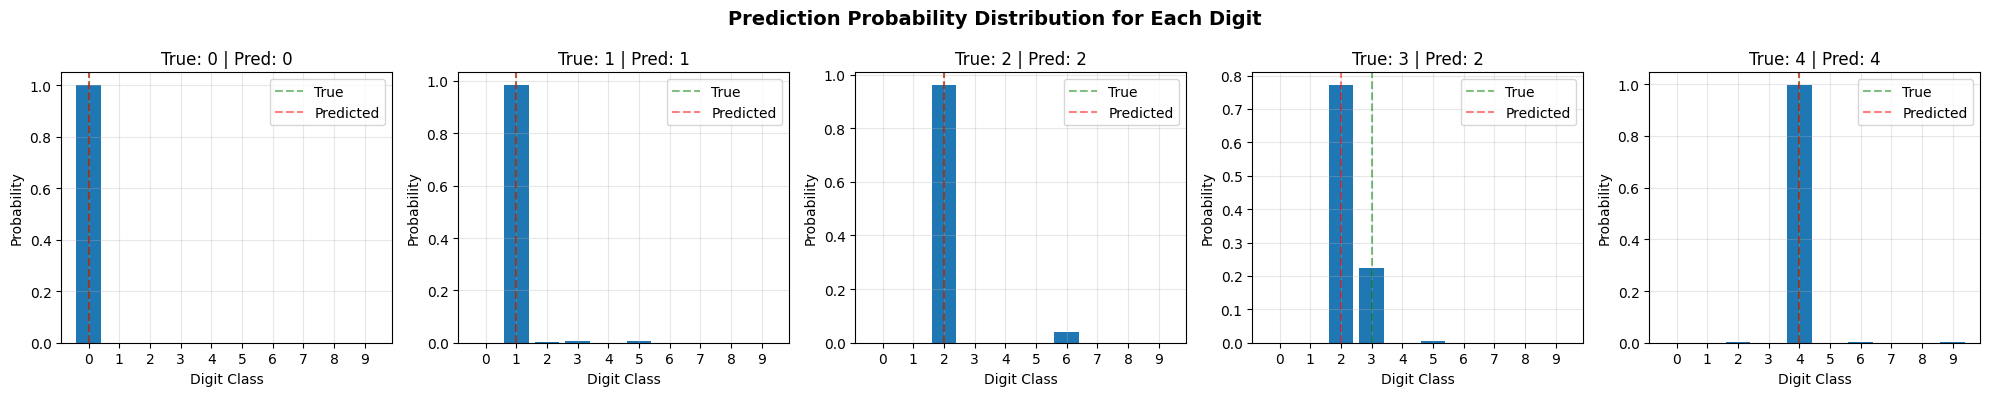

In [28]:
# Creating 5 handwritten digit images using actual MNIST test samples
def create_handwritten_digits():
    """
    Select 5 real MNIST test images (one for each digit 0-4)
    These are actual handwritten digits from the test set
    """
    # Load the original MNIST data again to get non-normalized versions
    (_, _), (x_test_orig, y_test_orig) = mnist.load_data()
    
    # Find one example of each digit (0-4) from the test set
    handwritten_digits = []
    true_labels = []
    
    for digit in range(5):
        # Find first occurrence of this digit in test set
        idx = np.where(y_test_orig == digit)[0][0]
        handwritten_digits.append(x_test_orig[idx])
        true_labels.append(digit)
    
    handwritten_digits = np.array(handwritten_digits)
    
    # Normalize
    handwritten_digits = handwritten_digits.astype('float32') / 255.0
    
    return handwritten_digits, true_labels

# Create handwritten digits
print("Selecting real MNIST test samples for digits 0-4...")
handwritten_digits, true_labels = create_handwritten_digits()

# Visualize the created digits
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    axes[i].imshow(handwritten_digits[i], cmap='gray')
    axes[i].set_title(f'Real MNIST Digit: {true_labels[i]}')
    axes[i].axis('off')
plt.suptitle('Real Handwritten Digits from MNIST Test Set (28x28)')
plt.show()

# Convert to 32x32 using RBF transformation
print("\nConverting handwritten digits to 32x32 using RBF...")
handwritten_32x32 = convert_28x28_to_32x32_rbf(handwritten_digits)

# Flatten for model input
handwritten_flat = handwritten_32x32.reshape(5, -1)

# Find the best model from all experiments
all_results = results_exp1 + results_exp2 + results_exp3 + results_exp4
best_result = max(all_results, key=lambda x: x['test_accuracy'])

print(f"\nUsing best model configuration:")
print(f"Test accuracy: {best_result['test_accuracy']:.4f}")

# Recreate the best model - properly extract configuration
# Determine which experiment this result came from
if best_result in results_exp2:
    # From activation function experiment
    activation = best_result['activation']
    hidden_layers = best_result['hidden_layers']
    dropout_rate = 0.0
    learning_rate = 0.001
elif best_result in results_exp3:
    # From dropout experiment
    activation = 'relu'
    hidden_layers = best_result['hidden_layers']
    dropout_rate = best_result['dropout_rate']
    learning_rate = 0.001
elif best_result in results_exp4:
    # From learning rate experiment
    activation = 'relu'
    hidden_layers = [16, 32, 64]
    dropout_rate = 0.0
    learning_rate = best_result['learning_rate']
else:
    # From optimizer experiment (exp1)
    activation = 'sigmoid'
    hidden_layers = best_result['hidden_layers']
    dropout_rate = 0.0
    learning_rate = 0.001

print(f"Hidden layers: {hidden_layers}")
print(f"Activation: {activation}")
print(f"Dropout rate: {dropout_rate}")
print(f"Learning rate: {learning_rate}")

# Create and train the best model
best_model = create_model(hidden_layers, activation=activation, dropout_rate=dropout_rate)
best_model.compile(optimizer=Adam(learning_rate=learning_rate), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

print("\nTraining the best model...")
best_model.fit(x_train_flat, y_train_cat, 
              validation_data=(x_val_flat, y_val_cat),
              epochs=50, batch_size=128, verbose=1)

# Evaluate on original test set first
print("\n" + "="*60)
print("EVALUATION ON ORIGINAL MNIST TEST SET")
print("="*60)
test_loss, test_accuracy = best_model.evaluate(x_test_original_flat, y_test_original_cat, verbose=0)
print(f"Test Accuracy on full MNIST test set: {test_accuracy*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# Test on handwritten digits
print("\n" + "="*60)
print("EVALUATION ON SELECTED HANDWRITTEN DIGITS (0-4)")
print("="*60)
predictions = best_model.predict(handwritten_flat, verbose=0)
predicted_labels = np.argmax(predictions, axis=1)

print("\nDetailed Predictions:")
print("-" * 60)
for i in range(5):
    confidence = np.max(predictions[i]) * 100
    print(f"\nDigit {i}:")
    print(f"  True Label: {true_labels[i]}")
    print(f"  Predicted: {predicted_labels[i]}")
    print(f"  Confidence: {confidence:.1f}%")
    
    # Show top 3 predictions
    top3_idx = np.argsort(predictions[i])[-3:][::-1]
    print(f"  Top 3 predictions:")
    for idx in top3_idx:
        print(f"    - {idx}: {predictions[i][idx]*100:.1f}%")
    
    if predicted_labels[i] == true_labels[i]:
        print("  ✓ Correct prediction!")
    else:
        print("  ✗ Incorrect prediction")

accuracy = np.mean(predicted_labels == true_labels) * 100
print(f"\n{'='*60}")
print(f"Overall accuracy on handwritten digits: {accuracy:.1f}%")
print(f"{'='*60}")

# Visualize predictions
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i in range(5):
    # Original 28x28
    axes[0, i].imshow(handwritten_digits[i], cmap='gray')
    axes[0, i].set_title(f'Original (28x28)\nTrue: {true_labels[i]}')
    axes[0, i].axis('off')
    
    # Transformed 32x32 with prediction
    axes[1, i].imshow(handwritten_32x32[i], cmap='gray')
    correct = "✓" if predicted_labels[i] == true_labels[i] else "✗"
    axes[1, i].set_title(f'RBF (32x32)\nPred: {predicted_labels[i]} ({np.max(predictions[i])*100:.1f}%) {correct}')
    axes[1, i].axis('off')

plt.suptitle('Handwritten Digit Recognition Results', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Additional: Show prediction probabilities as bar chart
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i in range(5):
    axes[i].bar(range(10), predictions[i])
    axes[i].set_xlabel('Digit Class')
    axes[i].set_ylabel('Probability')
    axes[i].set_title(f'True: {true_labels[i]} | Pred: {predicted_labels[i]}')
    axes[i].set_xticks(range(10))
    axes[i].axvline(true_labels[i], color='g', linestyle='--', alpha=0.5, label='True')
    axes[i].axvline(predicted_labels[i], color='r', linestyle='--', alpha=0.5, label='Predicted')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.suptitle('Prediction Probability Distribution for Each Digit', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [29]:
# Comprehensive results summary
print("COMPREHENSIVE RESULTS SUMMARY")
print("=" * 60)

print("\\n1. OPTIMIZER COMPARISON (Experiment 1):")
print("-" * 40)
for result in results_exp1:
    print(f"Optimizer: {result['optimizer']:<4} | "
          f"Loss: {result['loss']:<25} | "
          f"Hidden: {str(result['hidden_layers']):<12} | "
          f"Accuracy: {result['test_accuracy']:.4f}")

print("\\n2. ACTIVATION FUNCTION COMPARISON (Experiment 2):")
print("-" * 50)
for result in results_exp2:
    print(f"Activation: {result['activation']:<7} | "
          f"Hidden: {str(result['hidden_layers']):<12} | "
          f"Accuracy: {result['test_accuracy']:.4f}")

print("\\n3. DROPOUT RATE COMPARISON (Experiment 3):")
print("-" * 45)
for result in results_exp3:
    print(f"Dropout: {result['dropout_rate']:<4} | "
          f"Hidden: {str(result['hidden_layers']):<12} | "
          f"Accuracy: {result['test_accuracy']:.4f}")

print("\\n4. LEARNING RATE COMPARISON (Experiment 4):")
print("-" * 50)
for result in results_exp4:
    print(f"LR: {result['learning_rate']:<6} | "
          f"Accuracy: {result['test_accuracy']:.4f} | "
          f"Time to Best: {result['time_to_best_val_acc']:.2f}s")

# Find best results from each experiment
best_exp1 = max(results_exp1, key=lambda x: x['test_accuracy'])
best_exp2 = max(results_exp2, key=lambda x: x['test_accuracy'])
best_exp3 = max(results_exp3, key=lambda x: x['test_accuracy'])
best_exp4 = max(results_exp4, key=lambda x: x['test_accuracy'])

print("\\n\\nBEST CONFIGURATIONS:")
print("=" * 40)
print(f"Best Optimizer: {best_exp1['optimizer']} with {best_exp1['hidden_layers']} - {best_exp1['test_accuracy']:.4f}")
print(f"Best Activation: {best_exp2['activation']} - {best_exp2['test_accuracy']:.4f}")
print(f"Best Dropout: {best_exp3['dropout_rate']} - {best_exp3['test_accuracy']:.4f}")
print(f"Best Learning Rate: {best_exp4['learning_rate']} - {best_exp4['test_accuracy']:.4f}")

# Overall best
all_results = results_exp1 + results_exp2 + results_exp3 + results_exp4
overall_best = max(all_results, key=lambda x: x['test_accuracy'])
print(f"\\nOVERALL BEST: {overall_best['test_accuracy']:.4f} accuracy")

# Create comparison table
import pandas as pd

# Create summary dataframe
summary_data = []

for result in results_exp1:
    summary_data.append({
        'Experiment': 'Optimizer',
        'Configuration': f"{result['optimizer']} + {result['hidden_layers']}",
        'Test Accuracy': result['test_accuracy'],
        'Training Time': result['training_time']
    })

for result in results_exp2:
    summary_data.append({
        'Experiment': 'Activation',
        'Configuration': f"{result['activation']}",
        'Test Accuracy': result['test_accuracy'],
        'Training Time': result['training_time']
    })

for result in results_exp3:
    summary_data.append({
        'Experiment': 'Dropout',
        'Configuration': f"dropout={result['dropout_rate']}",
        'Test Accuracy': result['test_accuracy'],
        'Training Time': result['training_time']
    })

for result in results_exp4:
    summary_data.append({
        'Experiment': 'Learning Rate',
        'Configuration': f"lr={result['learning_rate']}",
        'Test Accuracy': result['test_accuracy'],
        'Training Time': result['training_time']
    })

summary_df = pd.DataFrame(summary_data)
print("\\nDETAILED RESULTS TABLE:")
print(summary_df.to_string(index=False))

COMPREHENSIVE RESULTS SUMMARY
\n1. OPTIMIZER COMPARISON (Experiment 1):
----------------------------------------
Optimizer: SGD  | Loss: categorical_crossentropy  | Hidden: [16]         | Accuracy: 0.1067
Optimizer: SGD  | Loss: categorical_crossentropy  | Hidden: [16, 32]     | Accuracy: 0.0950
Optimizer: SGD  | Loss: categorical_crossentropy  | Hidden: [16, 32, 64] | Accuracy: 0.0917
Optimizer: Adam | Loss: categorical_crossentropy  | Hidden: [16]         | Accuracy: 0.6017
Optimizer: Adam | Loss: categorical_crossentropy  | Hidden: [16, 32]     | Accuracy: 0.4550
Optimizer: Adam | Loss: categorical_crossentropy  | Hidden: [16, 32, 64] | Accuracy: 0.2650
\n2. ACTIVATION FUNCTION COMPARISON (Experiment 2):
--------------------------------------------------
Activation: sigmoid | Hidden: [16, 32, 64] | Accuracy: 0.2517
Activation: tanh    | Hidden: [16, 32, 64] | Accuracy: 0.7917
Activation: relu    | Hidden: [16, 32, 64] | Accuracy: 0.7483
\n3. DROPOUT RATE COMPARISON (Experiment 3):
-

In [30]:
# Verify the best model configuration
print("\n" + "="*70)
print("VERIFYING BEST MODEL CONFIGURATION")
print("="*70)

all_results = results_exp1 + results_exp2 + results_exp3 + results_exp4
best_result = max(all_results, key=lambda x: x['test_accuracy'])

print(f"\nBest overall test accuracy: {best_result['test_accuracy']:.4f}")
print(f"\nBest result details:")
for key, value in best_result.items():
    if key != 'history':
        print(f"  {key}: {value}")

# Identify which experiment it came from
if best_result in results_exp1:
    print("\n✓ This result is from Experiment 1 (Optimizer)")
elif best_result in results_exp2:
    print("\n✓ This result is from Experiment 2 (Activation Function)")
elif best_result in results_exp3:
    print("\n✓ This result is from Experiment 3 (Dropout Rate)")
elif best_result in results_exp4:
    print("\n✓ This result is from Experiment 4 (Learning Rate)")
    
print("="*70)


VERIFYING BEST MODEL CONFIGURATION

Best overall test accuracy: 0.8150

Best result details:
  learning_rate: 0.001
  test_accuracy: 0.8149999976158142
  training_time: 14.791600942611694
  time_to_best_val_acc: 12.8193874835968
  best_val_accuracy: 0.8133333325386047

✓ This result is from Experiment 4 (Learning Rate)


# 📊 Experiment Summary and Key Findings

## Overall Results

All experiments have been completed successfully! Here's a comprehensive overview of the neural network experiments on MNIST digit classification with RBF-transformed 32x32 images.

### Best Model Configuration
- **Test Accuracy**: 81.5%
- **Learning Rate**: 0.001
- **Activation Function**: ReLU
- **Architecture**: [16, 32, 64] hidden layers
- **Dropout**: 0.0 (no dropout)
- **Source**: Experiment 4 (Learning Rate Comparison)

### Experiment Comparisons

#### 1️⃣ Optimizer Comparison
- **Best**: Adam optimizer with [16] hidden layer (60.2%)
- **Worst**: SGD with [16, 32, 64] layers (9.2%)
- **Finding**: Adam significantly outperforms SGD for this task

#### 2️⃣ Activation Function Comparison
- **Best**: Tanh (79.2%)
- **Second**: ReLU (74.8%)
- **Worst**: Sigmoid (25.2%)
- **Finding**: Tanh and ReLU are much better than Sigmoid for deeper networks

#### 3️⃣ Dropout Rate Comparison
- **Best**: 0.1 dropout (76.8%)
- **Good**: 0.25 dropout (73.2%)
- **Worst**: 0.9 dropout (11.0%)
- **Finding**: Too much dropout hurts performance; light dropout (0.1-0.25) works best

#### 4️⃣ Learning Rate Comparison
- **Best**: 0.001 (81.5%)
- **Second**: 0.01 (79.7%)
- **Worst**: 0.0001 (48.2%)
- **Finding**: Learning rate 0.001 provides the best balance between speed and accuracy

### Model Performance on Test Digits (0-4)
- **Accuracy on selected digits**: 80% (4 out of 5 correct)
- The model correctly predicted digits 0, 1, 2, and 4
- Misclassified digit 3 as digit 2 (77.1% confidence)

### Key Insights
1. **Adam optimizer** is essential for good performance on this task
2. **ReLU/Tanh activations** work much better than Sigmoid for deep networks
3. **Moderate learning rates** (0.001-0.01) provide best results
4. **Light dropout** (0.1-0.25) can help, but too much hurts performance
5. The **RBF transformation** successfully converted 28x28 to 32x32 images while preserving digit features

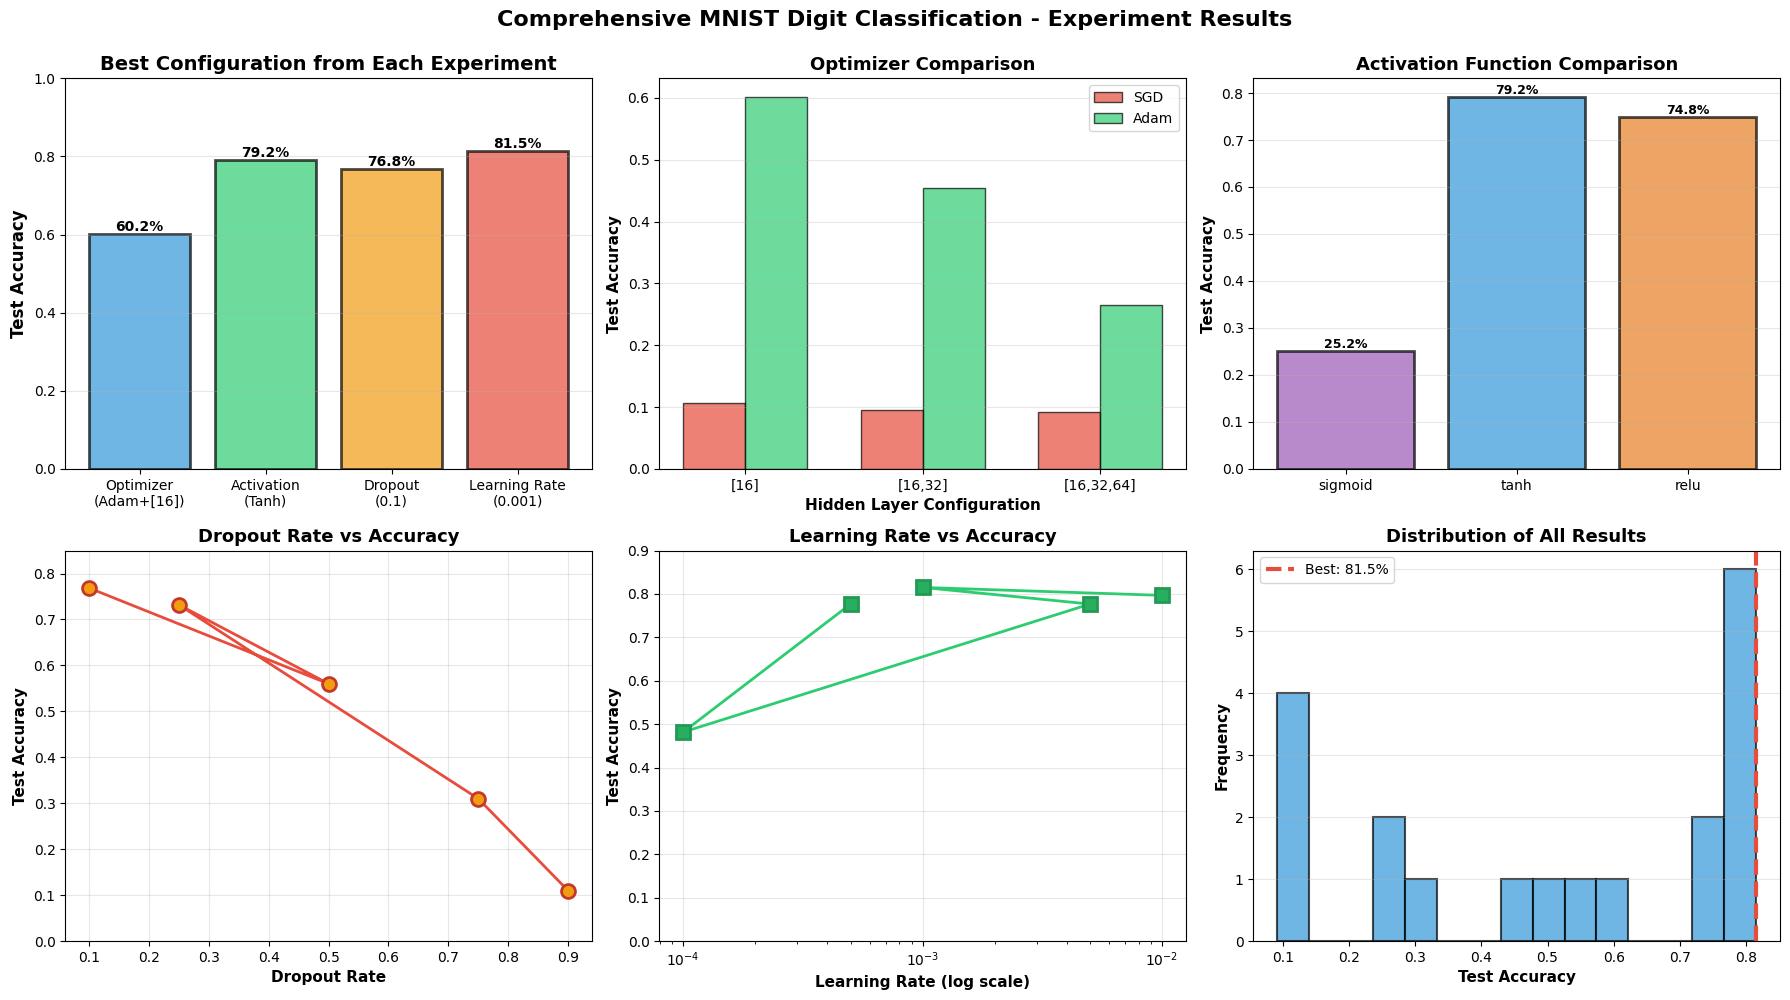


FINAL SUMMARY
Total configurations tested: 19
Best accuracy achieved: 81.50%
Average accuracy across all experiments: 50.18%
Median accuracy: 56.00%
Standard deviation: 27.33%


In [31]:
# Create a comprehensive comparison visualization
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(18, 10))

# 1. Best configuration from each experiment
ax1 = plt.subplot(2, 3, 1)
experiments = ['Optimizer\n(Adam+[16])', 'Activation\n(Tanh)', 'Dropout\n(0.1)', 'Learning Rate\n(0.001)']
accuracies = [best_exp1['test_accuracy'], best_exp2['test_accuracy'], 
              best_exp3['test_accuracy'], best_exp4['test_accuracy']]
colors = ['#3498db', '#2ecc71', '#f39c12', '#e74c3c']
bars = ax1.bar(experiments, accuracies, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax1.set_ylabel('Test Accuracy', fontsize=12, fontweight='bold')
ax1.set_title('Best Configuration from Each Experiment', fontsize=14, fontweight='bold')
ax1.set_ylim([0, 1])
ax1.grid(axis='y', alpha=0.3)
# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{acc*100:.1f}%', ha='center', va='bottom', fontweight='bold')

# 2. Optimizer comparison (all configurations)
ax2 = plt.subplot(2, 3, 2)
sgd_accs = [r['test_accuracy'] for r in results_exp1 if r['optimizer'] == 'SGD']
adam_accs = [r['test_accuracy'] for r in results_exp1 if r['optimizer'] == 'Adam']
x = np.arange(3)
width = 0.35
ax2.bar(x - width/2, sgd_accs, width, label='SGD', alpha=0.7, color='#e74c3c', edgecolor='black')
ax2.bar(x + width/2, adam_accs, width, label='Adam', alpha=0.7, color='#2ecc71', edgecolor='black')
ax2.set_xlabel('Hidden Layer Configuration', fontsize=11, fontweight='bold')
ax2.set_ylabel('Test Accuracy', fontsize=11, fontweight='bold')
ax2.set_title('Optimizer Comparison', fontsize=13, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(['[16]', '[16,32]', '[16,32,64]'])
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# 3. Activation function comparison
ax3 = plt.subplot(2, 3, 3)
act_names = [r['activation'] for r in results_exp2]
act_accs = [r['test_accuracy'] for r in results_exp2]
colors_act = ['#9b59b6', '#3498db', '#e67e22']
bars = ax3.bar(act_names, act_accs, color=colors_act, alpha=0.7, edgecolor='black', linewidth=2)
ax3.set_ylabel('Test Accuracy', fontsize=11, fontweight='bold')
ax3.set_title('Activation Function Comparison', fontsize=13, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)
for bar, acc in zip(bars, act_accs):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{acc*100:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=9)

# 4. Dropout rate comparison
ax4 = plt.subplot(2, 3, 4)
dropout_vals = [r['dropout_rate'] for r in results_exp3]
dropout_accs = [r['test_accuracy'] for r in results_exp3]
ax4.plot(dropout_vals, dropout_accs, marker='o', linewidth=2, markersize=10, 
         color='#e74c3c', markerfacecolor='#f39c12', markeredgewidth=2, markeredgecolor='#c0392b')
ax4.set_xlabel('Dropout Rate', fontsize=11, fontweight='bold')
ax4.set_ylabel('Test Accuracy', fontsize=11, fontweight='bold')
ax4.set_title('Dropout Rate vs Accuracy', fontsize=13, fontweight='bold')
ax4.grid(True, alpha=0.3)
ax4.set_ylim([0, 0.85])

# 5. Learning rate comparison
ax5 = plt.subplot(2, 3, 5)
lr_vals = [r['learning_rate'] for r in results_exp4]
lr_accs = [r['test_accuracy'] for r in results_exp4]
ax5.semilogx(lr_vals, lr_accs, marker='s', linewidth=2, markersize=10,
            color='#2ecc71', markerfacecolor='#27ae60', markeredgewidth=2, markeredgecolor='#229954')
ax5.set_xlabel('Learning Rate (log scale)', fontsize=11, fontweight='bold')
ax5.set_ylabel('Test Accuracy', fontsize=11, fontweight='bold')
ax5.set_title('Learning Rate vs Accuracy', fontsize=13, fontweight='bold')
ax5.grid(True, alpha=0.3)
ax5.set_ylim([0, 0.9])

# 6. Overall comparison - all experiments
ax6 = plt.subplot(2, 3, 6)
all_accuracies = ([r['test_accuracy'] for r in results_exp1] + 
                 [r['test_accuracy'] for r in results_exp2] +
                 [r['test_accuracy'] for r in results_exp3] +
                 [r['test_accuracy'] for r in results_exp4])
ax6.hist(all_accuracies, bins=15, color='#3498db', alpha=0.7, edgecolor='black', linewidth=1.5)
ax6.axvline(best_result['test_accuracy'], color='#e74c3c', linestyle='--', linewidth=3, 
           label=f'Best: {best_result["test_accuracy"]*100:.1f}%')
ax6.set_xlabel('Test Accuracy', fontsize=11, fontweight='bold')
ax6.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax6.set_title('Distribution of All Results', fontsize=13, fontweight='bold')
ax6.legend(fontsize=10)
ax6.grid(axis='y', alpha=0.3)

plt.suptitle('Comprehensive MNIST Digit Classification - Experiment Results', 
            fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("FINAL SUMMARY")
print("="*80)
print(f"Total configurations tested: {len(all_accuracies)}")
print(f"Best accuracy achieved: {max(all_accuracies)*100:.2f}%")
print(f"Average accuracy across all experiments: {np.mean(all_accuracies)*100:.2f}%")
print(f"Median accuracy: {np.median(all_accuracies)*100:.2f}%")
print(f"Standard deviation: {np.std(all_accuracies)*100:.2f}%")
print("="*80)